In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

# PAC Contribution Similarity Model

This model will examine the PAC contribution similarity between each member and the bill cosponsors

## Format the bills file
- Combine sponsors with cosponsors
- pull in amendment sponsors

In [13]:
cols =['body','session','bill_id','date',
       'sponsor_party','cs_count_r','cs_count_d', 'cosponsors',
       'topic','sponsor','bill_slug_official','bill_title','bill_slug','committee']
bills = pd.read_csv('../../propublica/bills.csv', names=cols)
bills.dropna(subset=['sponsor'], inplace = True)

C:\Users\Steve\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
def combine_sponsor(row):
    """Adds sponsor to list of cosponsors. Updates party count"""
    
    cosponsors = eval(row.cosponsors)[0]
    cs_count_r = row.cs_count_r
    cs_count_d = row.cs_count_d
    
    if row.sponsor not in cosponsors:
        cosponsors.append(row.sponsor)

        if row.sponsor_party == "R":
            cs_count_r += 1
        elif row.sponsor_party == "D":
            cs_count_d += 1
    return [row.bill_id, cosponsors, cs_count_r, cs_count_d]

In [22]:
bills = bills.apply(combine_sponsor, axis = 1).tolist()
bills = pd.DataFrame(bills, columns=['bill_id', 'cosponsors', 'cs_count_r', 'cs_count_d'])

In [24]:
bills.head()

,bill_id,cosponsors,cs_count_r,cs_count_d
0,hr4437-115,"[W000799, A000374, B001291, C001087, K000378, ...",8,1
1,hjres121-115,"[B001305, D000615, N000184, W000798, C001105, ...",16,0
2,hr4450-115,"[J000255, C001094, N000147, V000131]",2,2
3,hr4436-115,[G000582],1,0
4,hr4448-115,[S001148],1,0


In [25]:
amendments = pd.read_csv('../../propublica/amendments.csv')
amendments = amendments[['bill_id', 'accepted']]
bills = pd.merge(bills, amendments, how = 'left', on='bill_id')

In [45]:
members = pd.read_csv('../../propublica/members_all.csv', encoding='latin1')

In [52]:
party_lookup = {}
for i in members.session.unique():
    party_lookup[i] = {}
for i, row in members.iterrows():
    party_lookup[row.session][row.id] = row.party

In [62]:
def amendment_party(row):
    am_count_r = 0
    am_count_d = 0
    if pd.isnull(row.accepted):
        return [np.nan, np.nan]

    else:
        for mem_id in eval(row.accepted):
            p = party_lookup[int(row.bill_id.split("-")[1])]
            if p == 'D':
                am_count_d += 1
            elif p == 'R':
                am_count_r += 1
        return [am_count_r, am_count_d]
amendments = bills.apply(amendment_party, axis = 1).tolist()
amendments = pd.DataFrame(amendments, columns=['am_count_r', 'am_count_d'])
bills.reset_index(inplace=True, drop=True)
bills = pd.concat([bills, amendments], axis = 1)
bills.drop_duplicates(subset=['bill_id'], inplace=True)
bills.to_csv('../../propublica/bills_cosponsors.csv', index = False)

In [71]:
bills.head(1)

,bill_id,cosponsors,cs_count_r,cs_count_d,accepted,am_count_r,am_count_d
0,hr4437-115,"[W000799, A000374, B001291, C001087, K000378, ...",8,1,NaN,NaN,NaN


## Get Overall PAC cosine similarity

We are going to get cosine similarity between each member and all cosponsors for all PAC contributions (regardless of industry) in:
1. The previous election year.
2. The previous three election years.

These have already been calculated in a different notebook, so we just need to look them up. We will get central tendency statistics using pandas describe for each member X cosponsor set.

In [73]:
with open('../../campaign_contributions/open_secrets/processed/cosign_all_congress.pickle', 'rb') as f:
    contributions = pickle.load(f)
test = pd.read_csv('../test.csv')
train = pd.read_csv('../train.csv')
dev = pd.read_csv('../dev.csv')
dfs = [train, dev, test]

In [95]:
[len(df) for df in dfs]

[1164371, 582186, 194062]

In [97]:
test = pd.merge(test, bills, how = 'left', on = 'bill_id')
train = pd.merge(train, bills, how = 'left', on = 'bill_id')
dev = pd.merge(dev, bills, how = 'left', on = 'bill_id')

In [105]:
# missing 15% of data
dfs = [train, dev, test]
[df.cosponsors.isnull().sum() / len(df) for df in dfs]

[0.15967247552541244, 0.15921372207507567, 0.15999010625470211]

In [109]:
for df in dfs:
    df['cs_count'] = df.cs_count_r + df.cs_count_d
    df.dropna(subset=['cosponsors'], inplace = True)

In [110]:
train.head()

,full_set_id,member_id,party,vote_position,congress,roll_call,chamber,session,bill_id,majority_pos_rep,majority_pos_dem,broke_from_party,cosponsors,cs_count_r,cs_count_d,accepted,am_count_r,am_count_d,cs_count
0,1688860,P000449,R,Yes,114.0,179.0,Senate,1.0,hr644-114,Yes,Yes,0,"[T000462, S001179, C001106, K000376, G000564, ...",8.0,0.0,['H000338'],0.0,0.0,8.0
2,1805766,W000812,R,Yes,114.0,398.0,House,2.0,hr5485-114,Yes,No,0,[C001045],1.0,0.0,"['D000626', 'B001243', 'A000369', 'H001053', '...",0.0,0.0,1.0
3,370303,H000067,D,No,105.0,589.0,House,1.0,hres305-105,Yes,No,0,[S000675],1.0,0.0,[],0.0,0.0,1.0
4,515194,J000032,D,Yes,106.0,295.0,House,2.0,hr4201-106,Yes,No,1,"[T000058, L000096, S000822, S000364, G000210, ...",31.0,2.0,[''],0.0,0.0,33.0
5,368515,B000556,R,Yes,105.0,601.0,House,1.0,hr2386-105,Yes,No,0,"[C000830, G000152, G000212, J000174, M000481, ...",14.0,0.0,"['', 'B000403']",0.0,0.0,14.0


In [128]:
def cs_same_party(row):
    """Calculates the percentage of cosponsors that are of same party"""
    try:
        if row.party == 'D':
            numerator = row.cs_count_d
        elif row.party == 'R':
            numerator = row.cs_count_r
        return numerator / row.cs_count
        
        
    except:
        return np.nan

def cosponsor_cosign(row, span):
    """Get central tendency stats of cosign similarities between cosponsors and member"""
    cosponsors = row.cosponsors
    
    cosigns = []
    for cosponsor in cosponsors:
        try:
            cong_n = int(row.congress)
            members = (row.member_id, cosponsor)

            cosign = contributions[cong_n][span][members]
        except:
            cosign = np.nan
        cosigns.append(cosign)
    stats = pd.Series(cosigns).describe().to_dict()
    if pd.isnull(stats['std']):
        stats['std'] = 0
    return stats

def get_predictors(df_votes):
    df_votes['cosponsor_same_party'] = df_votes.apply(cs_same_party, axis =1)
    for span in ['p3', 'current']:
        df_cosponsor_cosign = df_votes.apply(cosponsor_cosign, span = span, axis = 1)
        df_cosponsor_cosign = pd.DataFrame(df_cosponsor_cosign.tolist(), index=df_cosponsor_cosign.index)
        df_cosponsor_cosign.columns = ["cs_" + span + "_" + x for x in df_cosponsor_cosign.columns]
        df_votes = pd.concat([df_votes, df_cosponsor_cosign], axis = 1)
    
    
    return df_votes

In [129]:
train, dev, test = map(get_predictors, dfs)

In [134]:
train.dropna(subset=['cs_p3_mean', 'cs_current_mean']).shape

(416020, 36)

In [136]:
# checkpoint!
train.to_csv('train_c1.csv', index = False)
dev.to_csv('dev_c1.csv', index = False)
test.to_csv('test_c1.csv', index = False)

## Get industry-specific PAC similarity
This is based on PACs that are active for a given committee. Cosine also calculated in a separate notebook

In [139]:
cols =['body','session','bill_id','date',
       'sponsor_party','cs_count_r','cs_count_d', 'cosponsors',
       'topic','sponsor','bill_slug_official','bill_title','bill_slug','committee','committee_code']
committees = pd.read_csv('../../propublica/bills2.csv', names=cols)
committees = committees[['bill_id', 'committee_code']]
committees.dropna(inplace=True)
committees.drop_duplicates(subset=['bill_id'], inplace=True)

C:\Users\Steve\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [147]:
dfs = [train, dev, test]
def join_committees(df_votes, committees = committees):
    df_votes = pd.merge(df_votes, committees, how = 'left', on = 'bill_id')
    return df_votes
train, dev, test = map(join_committees, dfs)

In [155]:
committee_cosine = {}
path = '../../campaign_contributions/open_secrets/processed/committees/'
for file in os.listdir(path):
    congress_num = int(file.split(".")[0][-3:])
    with open(path + file, 'rb') as f:
        
        committee_cosine[congress_num] = pickle.load(f)

In [162]:
def committee_cosign(row, span):
    """Get central tendency stats of cosine similarities 
    between cosponsors and member for committee PAC contributions"""
    cosponsors = row.cosponsors
    try:
        bill_committees = eval(row.committee_code)
    except:
        bill_committees = []
    cosigns = []
    for cosponsor in cosponsors:
        for bill_committee in bill_committees:
            try:
                cong_n = int(row.congress)
                members = (row.member_id, cosponsor)

                cosign = committee_cosine[cong_n][bill_committee][span][members]
            except:
                cosign = np.nan
            cosigns.append(cosign)
    stats = pd.Series(cosigns).describe().to_dict()
    if pd.isnull(stats['std']):
        stats['std'] = 0
    return stats

def get_predictors(df_votes):
    for span in ['p3', 'current']:
        df_cosponsor_cosign = df_votes.apply(committee_cosign, span = span, axis = 1)
        df_cosponsor_cosign = pd.DataFrame(df_cosponsor_cosign.tolist(), index=df_cosponsor_cosign.index)
        df_cosponsor_cosign.columns = ["com_" + span + "_" + x for x in df_cosponsor_cosign.columns]
        df_votes = pd.concat([df_votes, df_cosponsor_cosign], axis = 1)
    
    
    return df_votes

In [163]:
dfs = [train, dev, test]
train, dev, test = map(get_predictors, dfs)

In [165]:
# checkpoint!
train.to_csv('train_c2.csv', index = False)
dev.to_csv('dev_c2.csv', index = False)
test.to_csv('test_c2.csv', index = False)

## Initial Model
Will start with a no-frills logistic regression to see if feature set is worth pursuing

In [166]:
train.shape

(978453, 53)

In [169]:
train.head()

,full_set_id,member_id,party,vote_position,congress,roll_call,chamber,session,bill_id,majority_pos_rep,majority_pos_dem,broke_from_party,cosponsors,cs_count_r,cs_count_d,accepted,am_count_r,am_count_d,cs_count,cosponsor_same_party,cs_p3_25%,cs_p3_50%,cs_p3_75%,cs_p3_count,cs_p3_max,cs_p3_mean,cs_p3_min,cs_p3_std,cs_current_25%,cs_current_50%,cs_current_75%,cs_current_count,cs_current_max,cs_current_mean,cs_current_min,cs_current_std,committee_code,com_p3_25%,com_p3_50%,com_p3_75%,com_p3_count,com_p3_max,com_p3_mean,com_p3_min,com_p3_std,com_current_25%,com_current_50%,com_current_75%,com_current_count,com_current_max,com_current_mean,com_current_min,com_current_std
0,1688860,P000449,R,Yes,114.0,179.0,Senate,1.0,hr644-114,Yes,Yes,0,"[T000462, S001179, C001106, K000376, G000564, ...",8.0,0.0,['H000338'],0.0,0.0,8.0,1.000000,0.766293,0.784280,0.792026,6.0,0.961586,0.796232,0.692337,0.089060,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,['HSWM'],0.906999,0.952209,0.953485,6.0,0.974722,0.932448,0.869707,0.041407,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
1,1805766,W000812,R,Yes,114.0,398.0,House,2.0,hr5485-114,Yes,No,0,[C001045],1.0,0.0,"['D000626', 'B001243', 'A000369', 'H001053', '...",0.0,0.0,1.0,1.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,['HSAP'],NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
2,370303,H000067,D,No,105.0,589.0,House,1.0,hres305-105,Yes,No,0,[S000675],1.0,0.0,[],0.0,0.0,1.0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
3,515194,J000032,D,Yes,106.0,295.0,House,2.0,hr4201-106,Yes,No,1,"[T000058, L000096, S000822, S000364, G000210, ...",31.0,2.0,[''],0.0,0.0,33.0,0.060606,0.607485,0.621555,0.625903,5.0,0.676521,0.619793,0.567499,0.039194,0.72798,0.738136,0.748842,5.0,0.753055,0.731779,0.690881,0.024856,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
4,368515,B000556,R,Yes,105.0,601.0,House,1.0,hr2386-105,Yes,No,0,"[C000830, G000152, G000212, J000174, M000481, ...",14.0,0.0,"['', 'B000403']",0.0,0.0,14.0,1.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0


In [174]:
# using industry specific PAC contributions, really cuts down the sample size
train.dropna(subset=[col for col in train.columns if "current" in col]).shape

(224313, 53)

In [173]:
# better with whole industry
train.dropna(subset=[col for col in train.columns if col.startswith('cs')]).shape

(416020, 53)

### No Industry Specific PAC Contribution Similarities

In [337]:
# keep relevant columns, dropna
drop = ['am_count_r', 'am_count_d','accepted']
keep_cols = [col for col in train.columns if col.startswith('com') == False and col not in drop]
cols = [col for col in train.columns if col.startswith('cs')]
dfs = [train, dev, test]
model_train, model_dev, model_test = map(lambda df: df[keep_cols].dropna(subset = cols), dfs)

In [221]:
model_train.head()

,full_set_id,member_id,party,vote_position,congress,roll_call,chamber,session,bill_id,majority_pos_rep,majority_pos_dem,broke_from_party,cosponsors,cs_count_r,cs_count_d,cs_count,cosponsor_same_party,cs_p3_25%,cs_p3_50%,cs_p3_75%,cs_p3_count,cs_p3_max,cs_p3_mean,cs_p3_min,cs_p3_std,cs_current_25%,cs_current_50%,cs_current_75%,cs_current_count,cs_current_max,cs_current_mean,cs_current_min,cs_current_std
3,515194,J000032,D,Yes,106.0,295.0,House,2.0,hr4201-106,Yes,No,1,"[T000058, L000096, S000822, S000364, G000210, ...",31.0,2.0,33.0,0.060606,0.607485,0.621555,0.625903,5.0,0.676521,0.619793,0.567499,0.039194,0.727980,0.738136,0.748842,5.0,0.753055,0.731779,0.690881,0.024856
5,1877718,W000813,R,Yes,115.0,223.0,House,1.0,hr876-115,Yes,Yes,0,"[M001157, R000575, F000466, H001077, K000210, ...",6.0,3.0,9.0,0.666667,0.411084,0.655361,0.797361,9.0,0.869820,0.634261,0.393292,0.199035,0.573759,0.746857,0.856979,9.0,0.935057,0.677343,-0.000008,0.291093
6,1003396,B000575,R,No,110.0,96.0,House,2.0,hres1014-110,No,Yes,0,[C001066],0.0,1.0,1.0,0.000000,0.413537,0.413537,0.413537,1.0,0.413537,0.413537,0.413537,0.000000,0.353818,0.353818,0.353818,1.0,0.353818,0.353818,0.353818,0.000000
7,1890431,Y000062,D,Yes,115.0,248.0,House,1.0,hr1665-115,Yes,Yes,0,"[B001286, K000378, B001295, S000364, L000585, ...",7.0,1.0,8.0,0.125000,0.620525,0.647345,0.688788,8.0,0.966661,0.681119,0.544255,0.127390,0.611818,0.635285,0.665306,8.0,0.888938,0.646588,0.474691,0.117743
9,1384055,B000574,D,No,112.0,945.0,House,1.0,hres502-112,Yes,No,0,[S001184],1.0,0.0,1.0,0.000000,0.439508,0.439508,0.439508,1.0,0.439508,0.439508,0.439508,0.000000,0.319765,0.319765,0.319765,1.0,0.319765,0.319765,0.319765,0.000000


In [338]:
def include_interactions(df):
    """Calculate pac contribution interactions with:
        1. Cosponsor party ratio
        2. Congress Number (to account for decrease in quality of PAC data in earlier years)
    """
    columns = [x for x in df.columns if x.startswith('cs_')]
    
    # consponsor party ration
    interactions = df[columns].mul(df.cosponsor_same_party, axis = 0)
    interactions.columns = ["int_party_" + col for col in interactions.columns]
    df = pd.concat([df, interactions], axis = 1)
    
    # congress number. 
    # 115 has essentially complete data. it declines precipitously from there
    interactions = df[columns].mul(df.congress >= 113, axis = 0)
    interactions.columns = ["int_congress_" + col for col in interactions.columns]
    df = pd.concat([df, interactions], axis = 1)
    df['post_112'] = df.congress >= 113
    return df

dfs = [model_train, model_dev, model_test]
model_train, model_dev, model_test = map(include_interactions, dfs)

In [232]:
model_train.head(2)

,full_set_id,member_id,party,vote_position,congress,roll_call,chamber,session,bill_id,majority_pos_rep,majority_pos_dem,broke_from_party,cosponsors,cs_count_r,cs_count_d,cs_count,cosponsor_same_party,cs_p3_25%,cs_p3_50%,cs_p3_75%,cs_p3_count,cs_p3_max,cs_p3_mean,cs_p3_min,cs_p3_std,cs_current_25%,cs_current_50%,cs_current_75%,cs_current_count,cs_current_max,cs_current_mean,cs_current_min,cs_current_std,int_party_cs_count_r,int_party_cs_count_d,int_party_cs_count,int_party_cs_p3_25%,int_party_cs_p3_50%,int_party_cs_p3_75%,int_party_cs_p3_count,int_party_cs_p3_max,int_party_cs_p3_mean,int_party_cs_p3_min,int_party_cs_p3_std,int_party_cs_current_25%,int_party_cs_current_50%,int_party_cs_current_75%,int_party_cs_current_count,int_party_cs_current_max,int_party_cs_current_mean,int_party_cs_current_min,int_party_cs_current_std,int_congress_cs_count_r,int_congress_cs_count_d,int_congress_cs_count,int_congress_cs_p3_25%,int_congress_cs_p3_50%,int_congress_cs_p3_75%,int_congress_cs_p3_count,int_congress_cs_p3_max,int_congress_cs_p3_mean,int_congress_cs_p3_min,int_congress_cs_p3_std,int_congress_cs_current_25%,int_congress_cs_current_50%,int_congress_cs_current_75%,int_congress_cs_current_count,int_congress_cs_current_max,int_congress_cs_current_mean,int_congress_cs_current_min,int_congress_cs_current_std,post_112
3,515194,J000032,D,Yes,106.0,295.0,House,2.0,hr4201-106,Yes,No,1,"[T000058, L000096, S000822, S000364, G000210, ...",31.0,2.0,33.0,0.060606,0.607485,0.621555,0.625903,5.0,0.676521,0.619793,0.567499,0.039194,0.727980,0.738136,0.748842,5.0,0.753055,0.731779,0.690881,0.024856,1.878788,0.121212,2.0,0.036817,0.037670,0.037934,0.30303,0.041001,0.037563,0.034394,0.002375,0.044120,0.044736,0.045384,0.30303,0.045640,0.044350,0.041872,0.001506,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,False
5,1877718,W000813,R,Yes,115.0,223.0,House,1.0,hr876-115,Yes,Yes,0,"[M001157, R000575, F000466, H001077, K000210, ...",6.0,3.0,9.0,0.666667,0.411084,0.655361,0.797361,9.0,0.869820,0.634261,0.393292,0.199035,0.573759,0.746857,0.856979,9.0,0.935057,0.677343,-0.000008,0.291093,4.000000,2.000000,6.0,0.274056,0.436907,0.531574,6.00000,0.579880,0.422841,0.262195,0.132690,0.382506,0.497905,0.571319,6.00000,0.623371,0.451562,-0.000005,0.194062,6.0,3.0,9.0,0.411084,0.655361,0.797361,9.0,0.86982,0.634261,0.393292,0.199035,0.573759,0.746857,0.856979,9.0,0.935057,0.677343,-0.000008,0.291093,True


In [234]:
drop = ['full_set_id','member_id','party', 'vote_position',
        'congress','roll_call','chamber','session', 'bill_id', 
        'majority_pos_rep', 'majority_pos_dem', 'broke_from_party', 
        'cosponsors', 'cs_count_r', 'cs_count_d']
predictors = [x for x in model_train.columns if x not in drop]
lgr = LogisticRegression()
lgr.fit(model_train[predictors], model_train['broke_from_party'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [279]:
# get baseline with this subset of data
# could differ from overall baseline
# because we had to drop a large subset from earlier years
# increase over baseline simply because breaking from party is more rare in recent years
print(metrics.classification_report(model_dev['broke_from_party'], np.zeros(len(model_dev)), digits=4))

             precision    recall  f1-score   support

          0     0.9578    1.0000    0.9784    199391
          1     0.0000    0.0000    0.0000      8789

avg / total     0.9173    0.9578    0.9371    208180



C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [238]:
probs_dev = lgr.predict_proba(model_dev[predictors])[:,1]

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


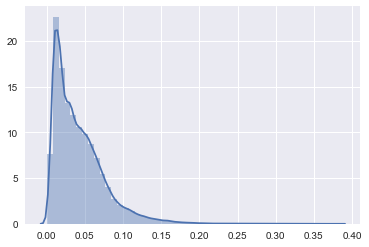

In [247]:
# with .5 threshold, model will predict no breaking with party
sns.distplot(probs_dev)

In [258]:
def find_best_threshold(probs, y_true):
    """Find threshold that results in best overall f1 score"""
    
    cuts = [np.percentile(probs,x) for x in np.linspace(10,100,100)]
    f1 = []
    for threshold in cuts:
        pred = probs >= threshold
        f1.append([threshold, metrics.f1_score(y_true, pred, average='weighted')])
    f1 = pd.DataFrame(f1, columns=['threshold','f1'])
    threshold = f1.threshold[f1.f1.idxmax()]
    
    return threshold
probs_train = lgr.predict_proba(model_train[predictors])[:,1]
find_best_threshold(probs_train, model_train['broke_from_party'])


0.36395449505397143

In [260]:
# not a geat model
# maybe it will be able to contribute to the final ensemble
# there is afterall, some variation in predicted probabilities
threshold = find_best_threshold(probs_train, model_train['broke_from_party'])
(probs_dev > threshold).sum()

1

In [266]:
np.percentile(probs_train, 100 - (model_train['broke_from_party'].mean() * 100))

0.11190374610503878

In [292]:
(probs_dev >= .19).sum()

658

In [293]:
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= .19, digits=4))

             precision    recall  f1-score   support

          0     0.9583    0.9974    0.9775    199391
          1     0.2158    0.0162    0.0301      8789

avg / total     0.9270    0.9560    0.9375    208180



In [289]:
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= .135, digits=4))

             precision    recall  f1-score   support

          0     0.9604    0.9827    0.9714    199391
          1     0.1711    0.0808    0.1097      8789

avg / total     0.9271    0.9447    0.9351    208180



In [278]:
# coefficients
coefficients = pd.DataFrame(lgr.coef_, columns = model_train[predictors].columns).T
coefficients.sort_values(by = 0)

,0
int_congress_cs_current_std,-3.909052
int_party_cs_p3_std,-3.166097
int_party_cs_p3_25%,-2.798725
int_party_cs_current_std,-2.722090
int_party_cs_p3_75%,-2.650733
int_party_cs_current_max,-1.958923
cs_current_mean,-1.848440
int_congress_cs_p3_25%,-1.771815
int_congress_cs_current_50%,-1.552382
cs_p3_max,-1.180797


In [298]:
pd.DataFrame(probs_dev, index = model_dev.full_set_id, columns=['pred_probs'])

,pred_probs
full_set_id,
1477742,0.021830
1236658,0.022014
1175000,0.015892
1843971,0.024093
1647665,0.016601
1164103,0.074357
1496784,0.036572
1889873,0.052027
489951,0.065159


In [295]:
with open('lgr_pac_general1.pickle', 'wb') as f:
    pickle.dump(lgr, f)

In [302]:
def export_predictions(dfs, model, file_name, 
                       path = "../model_predictions/", 
                       predictors = predictors):
    """Exports probabilities for all sets
    Args:
        dfs: train, dev, test sets. in that order.
        model: sklearn model to get predictions
        path: where to export
        predictors: Column set to use as predictors
    """
    labels = ['train', 'dev', 'test']
    for label, df in zip(labels, dfs):
        probs = model.predict_proba(df[predictors])[:,1]
        probs = pd.DataFrame(probs, index = df.full_set_id, columns=['pred_probs'])
        probs.to_csv(path + file_name + "_" + label + ".csv")
        
dfs = [model_train, model_dev, model_test]
export_predictions(dfs, lgr, 'pac_general')

In [340]:
drop = ['full_set_id','member_id','party', 'vote_position',
        'congress','roll_call','chamber','session', 'bill_id', 
        'majority_pos_rep', 'majority_pos_dem', 'broke_from_party', 
        'cosponsors', 'cs_count_r', 'cs_count_d']
predictors = [x for x in model_train.columns if x not in drop]

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


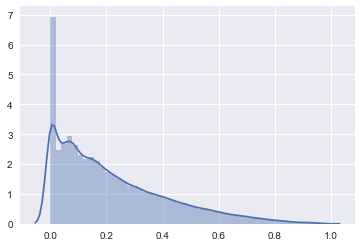

In [341]:
rfc = RandomForestClassifier(class_weight='balanced', min_samples_split=100)
rf_pred = [x for x in predictors if x.startswith('int_') == False]
rfc.fit(model_train[rf_pred], model_train['broke_from_party'])
probs_dev = rfc.predict_proba(model_dev[rf_pred])[:,1]
probs_train = rfc.predict_proba(model_train[rf_pred])[:,1]
sns.distplot(probs_dev)

In [344]:
print((probs_dev >= .7).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= .7, digits=4))

5644
             precision    recall  f1-score   support

          0     0.9670    0.9823    0.9746    199391
          1     0.3733    0.2397    0.2920      8789

avg / total     0.9419    0.9509    0.9458    208180



### Industry Specific PAC contributions
Committees were mapped to PAC industries. Will use PAC contribution similarity between member and sponsor just for the top PAC industries associated with the respective congressional committees involved in each bill. Will follow the same general approach as above, so code will be very similar.

In [303]:
# keep relevant columns, dropna
drop = ['am_count_r', 'am_count_d','accepted']
keep_cols = [col for col in train.columns if col.startswith('cs_') == False and col not in drop]
cols = [col for col in train.columns if col.startswith('com')]
dfs = [train, dev, test]
model_train, model_dev, model_test = map(lambda df: df[keep_cols].dropna(subset = cols), dfs)

In [305]:
def include_interactions(df):
    """Calculate pac contribution interactions with:
        1. Cosponsor party ratio
        2. Congress Number (to account for decrease in quality of PAC data in earlier years)
    """
    columns = [x for x in df.columns if x.startswith('com_')]
    
    # consponsor party ration
    interactions = df[columns].mul(df.cosponsor_same_party, axis = 0)
    interactions.columns = ["int_party_" + col for col in interactions.columns]
    df = pd.concat([df, interactions], axis = 1)
    
    # congress number. 
    # 115 has essentially complete data. it declines precipitously from there
    interactions = df[columns].mul(df.congress >= 113, axis = 0)
    interactions.columns = ["int_congress_" + col for col in interactions.columns]
    df = pd.concat([df, interactions], axis = 1)
    df['post_112'] = df.congress >= 113
    return df

dfs = [model_train, model_dev, model_test]
model_train, model_dev, model_test = map(include_interactions, dfs)

In [309]:
drop = ['full_set_id','member_id','party', 'vote_position',
        'congress','roll_call','chamber','session', 'bill_id', 
        'majority_pos_rep', 'majority_pos_dem', 'broke_from_party', 
        'cosponsors', 'cs_count_r', 'cs_count_d', 'committee_code']
predictors = [x for x in model_train.columns if x not in drop]
lgr = LogisticRegression()
lgr.fit(model_train[predictors], model_train['broke_from_party'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [310]:
# baseline
print(metrics.classification_report(model_dev['broke_from_party'], np.zeros(len(model_dev)), digits=4))

             precision    recall  f1-score   support

          0     0.9668    1.0000    0.9831    109160
          1     0.0000    0.0000    0.0000      3748

avg / total     0.9347    0.9668    0.9505    112908



C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [311]:
probs_dev = lgr.predict_proba(model_dev[predictors])[:,1]
probs_train = lgr.predict_proba(model_train[predictors])[:,1]

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


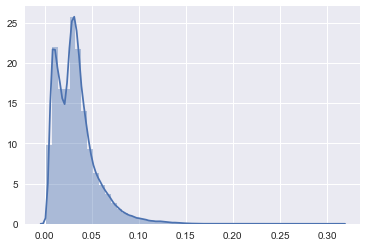

In [312]:
# bimodal! nice! Still really low probs though
sns.distplot(probs_dev)

In [313]:
threshold = find_best_threshold(probs_train, model_train['broke_from_party'])
(probs_dev > threshold).sum()

0

In [317]:
(probs_dev >= .10).sum()

1716

In [315]:
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= .10, digits=4))

             precision    recall  f1-score   support

          0     0.9682    0.9862    0.9771    109160
          1     0.1212    0.0555    0.0761      3748

avg / total     0.9400    0.9553    0.9472    112908



In [318]:
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= .08, digits=4))

             precision    recall  f1-score   support

          0     0.9693    0.9649    0.9671    109160
          1     0.0962    0.1089    0.1021      3748

avg / total     0.9403    0.9365    0.9384    112908



In [319]:
# coefficients
coefficients = pd.DataFrame(lgr.coef_, columns = model_train[predictors].columns).T
coefficients.sort_values(by = 0)

,0
int_party_com_p3_max,-1.980331
post_112,-1.896595
int_party_com_current_max,-1.143704
int_party_com_current_50%,-1.020174
int_party_com_current_25%,-0.907771
int_congress_com_current_min,-0.681268
com_current_min,-0.681268
com_p3_mean,-0.662553
int_congress_com_p3_mean,-0.662553
int_party_com_current_mean,-0.513247


In [324]:
rfc = RandomForestClassifier(class_weight='balanced', min_samples_split=100)
rf_pred = [x for x in predictors if x.startswith('int_') == False]
rfc.fit(model_train[rf_pred], model_train['broke_from_party'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


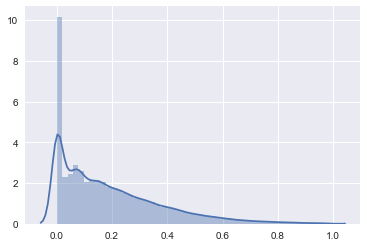

In [327]:
probs_dev = rfc.predict_proba(model_dev[rf_pred])[:,1]
probs_train = rfc.predict_proba(model_train[rf_pred])[:,1]
sns.distplot(probs_dev)

In [334]:
print((probs_dev >= .7).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= .7, digits=4))

2214
             precision    recall  f1-score   support

          0     0.9737    0.9873    0.9805    109160
          1     0.3758    0.2220    0.2791      3748

avg / total     0.9538    0.9619    0.9572    112908



In [336]:
with open('rfc_pac_industry1.pickle', 'wb') as f:
    pickle.dump(rfc, f)
dfs = [model_train, model_dev, model_test]
export_predictions(dfs, rfc, 'pac_industry', predictors=rf_pred)